# WT-Flow (learned flow whitening) + kNN

## Imports + WT-Flow classes

In [1]:
DINOV3_LOCATION = r"C:\Users\snehi\Documents\Deep Learning\dinov3"
WEIGHTS = r"C:\Users\snehi\Documents\Deep Learning\dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth"

In [2]:
import os
from glob import glob
from pathlib import Path

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt

## AffineCoupling + WTFlow

“WT-Flow model: affine coupling flow (RealNVP-style)” means
we’re using a specific type of normalizing flow (built from affine coupling layers like in RealNVP) to transform DINO patch features so that normal patches become Gaussian in the new space, making anomalies easier to detect.

In [3]:
class AffineCoupling(nn.Module):
    """
    Simple RealNVP-style affine coupling layer.
    Splits features into two halves: x = [x1, x2].
    Uses x1 to predict scale/shift for x2.
    """
    def __init__(self, dim, hidden_dim=512):
        super().__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim

        # mask for splitting: first half, second half
        self.register_buffer("mask", self._create_mask(dim))

        in_dim = dim // 2
        out_dim = dim // 2

        # small MLP to predict s(x1), t(x1)
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * out_dim)  # outputs [s, t]
        )

    def _create_mask(self, dim):
        mask = torch.zeros(dim)
        mask[: dim // 2] = 1.0
        return mask

    def forward(self, x):
        """
        x: [B, D]
        returns: z, log_det_J
        """
        x1 = x * self.mask          # first half
        x2 = x * (1 - self.mask)    # second half

        # gather active part (non-zero entries)
        x1_active = x1[:, : self.dim // 2]  # [B, D/2]

        # predict scale (s) and shift (t) for x2
        st = self.net(x1_active)           # [B, D]
        s, t = torch.chunk(st, 2, dim=1)   # each [B, D/2]

        # apply affine transform only on second half
        x2_active = x2[:, self.dim // 2 :]
        z2 = x2_active * torch.exp(s) + t

        # recombine: [x1, z2] in correct positions
        z = torch.zeros_like(x)
        z[:, : self.dim // 2] = x1_active
        z[:, self.dim // 2 :] = z2

        # log-det of Jacobian: sum(s) over second half
        log_det_J = s.sum(dim=1)  # [B]

        return z, log_det_J

    def inverse(self, z):
        #Inverse pass: given z, recover x.
        
        z1 = z * self.mask
        z2 = z * (1 - self.mask)

        z1_active = z1[:, : self.dim // 2]

        st = self.net(z1_active)
        s, t = torch.chunk(st, 2, dim=1)

        z2_active = z2[:, self.dim // 2 :]
        x2 = (z2_active - t) * torch.exp(-s)

        x = torch.zeros_like(z)
        x[:, : self.dim // 2] = z1_active
        x[:, self.dim // 2 :] = x2

        return x
        

class WTFlow(nn.Module):
    #Whitening Transform Flow: stack of affine coupling layers + permutations. Learns to map x ~ p_data to z ~ N(0, I).
    
    def __init__(self, dim, num_layers=4, hidden_dim=512):
        super().__init__()
        self.dim = dim
        self.num_layers = num_layers

        self.layers = nn.ModuleList([
            AffineCoupling(dim, hidden_dim=hidden_dim) for _ in range(num_layers)
        ])

        # simple permutations between layers
        perms = []
        base_perm = torch.arange(dim)
        for i in range(num_layers):
            perm = base_perm[torch.randperm(dim)]
            perms.append(perm)
        self.register_buffer("perms", torch.stack(perms))  # [num_layers, dim]

        # inverse permutations
        inv_perms = []
        for i in range(num_layers):
            perm = self.perms[i]
            inv = torch.empty_like(perm)
            inv[perm] = torch.arange(dim, device=perm.device)
            inv_perms.append(inv)
        self.register_buffer("inv_perms", torch.stack(inv_perms))

    def _permute(self, x, layer_idx):
        return x[:, self.perms[layer_idx]]

    def _inverse_permute(self, x, layer_idx):
        return x[:, self.inv_perms[layer_idx]]

    def forward(self, x):
        """
        x: [B, D]
        returns z, log_det_J_total
        """
        log_det_total = torch.zeros(x.size(0), device=x.device)
        z = x
        for i, layer in enumerate(self.layers):
            z = self._permute(z, i)
            z, log_det = layer(z)
            log_det_total += log_det
        return z, log_det_total

    def inverse(self, z):
        x = z
        for i in reversed(range(self.num_layers)):
            layer = self.layers[i]
            x = layer.inverse(x)
            x = self._inverse_permute(x, i)
        return x

## PATHS, dataset, transforms, DINOv3, feature extractor

In [4]:
# PATHS

# Root folder containing mvtec_anomaly_detection
DATA_ROOT = r"C:\Users\snehi\Documents\Deep Learning\mvtec_anomaly_detection"

CLASS_NAME = "leather" 
# Reuse  existing DINOv3 paths
DINOv3_REPO = DINOV3_LOCATION      
DINOV3_WEIGHTS = WEIGHTS           

print("DATA_ROOT:", DATA_ROOT)
print("CLASS_NAME:", CLASS_NAME)
print("DINOv3_REPO:", DINOv3_REPO)
print("DINOv3_WEIGHTS:", DINOV3_WEIGHTS)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

DATA_ROOT: C:\Users\snehi\Documents\Deep Learning\mvtec_anomaly_detection
CLASS_NAME: leather
DINOv3_REPO: C:\Users\snehi\Documents\Deep Learning\dinov3
DINOv3_WEIGHTS: C:\Users\snehi\Documents\Deep Learning\dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth
Device: cpu


In [5]:
# DATASET CLASS (MVTecDataset)

class MVTecDataset(Dataset):
    def __init__(self, root, class_name, split="train", transform=None):
        super().__init__()
        assert split in ["train", "test"]
        self.root = root
        self.class_name = class_name
        self.split = split
        self.transform = transform

        # root/class_name/split/*/*.*
        pattern = os.path.join(root, class_name, split, "*", "*.*")
        paths = sorted(glob(pattern))

        if split == "train":
            paths = [p for p in paths if "good" in Path(p).parts]

        self.image_paths = paths

        self.labels = []
        if split == "test":
            for p in self.image_paths:
                if "good" in Path(p).parts:
                    self.labels.append(0)
                else:
                    self.labels.append(1)
        else:
            self.labels = [0] * len(self.image_paths)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img_t = self.transform(img)
        else:
            img_t = T.ToTensor()(img)

        label = self.labels[idx]
        return img_t, label, img_path
    

# TRANSFORMS + DATALOADER

IMG_SIZE = 224

transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    ),
])

train_dataset = MVTecDataset(DATA_ROOT, CLASS_NAME, split="train", transform=transform)
test_dataset  = MVTecDataset(DATA_ROOT, CLASS_NAME, split="test",  transform=transform)

print("Train images:", len(train_dataset))
print("Test images:", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False,
                          num_workers=0, pin_memory=True)

Train images: 245
Test images: 124


In [6]:
# load DINOv3 locally

# 2m 
dinov3_model = torch.hub.load(
    DINOv3_REPO,          # <- DINOV3_LOCATION
    'dinov3_vitb16',
    source='local',
    weights=DINOV3_WEIGHTS,
)
dinov3_model.eval().to(device)

print(dinov3_model)

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (rope_embed): RopePositionEmbedding()
  (blocks): ModuleList(
    (0-11): 12 x SelfAttentionBlock(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv): LinearKMaskedBias(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
    )
  )
  (norm): LayerN

In [7]:
# FEATURE EXTRACTOR
"""
tranforming input from shape [B,3,H,W] to [B,D,Hf,Wf]
D is embedding dim and Hf*Wf = number of patch tokens.
"""
class DINOv3FeatureExtractor(nn.Module):
    def __init__(self, dino_model):
        super().__init__()
        self.dino = dino_model

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feats = self.dino.forward_features(x)
        patch_tokens = feats["x_norm_patchtokens"]  # [B, N, D]
        B, N, D = patch_tokens.shape

        side = int(N ** 0.5)
        assert side * side == N, f"Patch count {N} is not a perfect square"
        Hf = Wf = side

        patch_tokens = patch_tokens.view(B, Hf, Wf, D)
        patch_map = patch_tokens.permute(0, 3, 1, 2).contiguous()  # [B, D, Hf, Wf]
        return patch_map

feature_extractor = DINOv3FeatureExtractor(dinov3_model)
feature_extractor.eval().to(device)

DINOv3FeatureExtractor(
  (dino): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (rope_embed): RopePositionEmbedding()
    (blocks): ModuleList(
      (0-11): 12 x SelfAttentionBlock(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): SelfAttention(
          (qkv): LinearKMaskedBias(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0,

## Baseline memory bank (for WT-Flow training)

- baseline DINOv3 patch features (only L2-normalized)

- WT-Flow learn a normalizing flow on the memory bank patches so that transformed features are close to standard Gaussian. we use the baseline memory bank, These features are raw DINO patch embeddings (L2-normalized only).
Perfect input for learning a flow transform that maps them to a standard Gaussian.



In [8]:
# transform memory bank (memory_bank_wt) 
memory_bank = []

with torch.no_grad():
    for batch_idx, (imgs, labels, paths) in enumerate(train_loader):
        imgs = imgs.to(device)
        feats = feature_extractor(imgs)  # [B,D,Hf,Wf]
        B, C, Hf, Wf = feats.shape

        feats = feats.view(B, C, -1)       # [B,C,N]
        feats = feats.permute(0, 2, 1)     # [B,N,C]
        feats = feats.reshape(-1, C)       # [B*N,C]
        feats = F.normalize(feats, dim=1)  # unit norm

        memory_bank.append(feats.cpu())

memory_bank = torch.cat(memory_bank, dim=0)  # [N_mem, C]
print("Memory bank shape:", memory_bank.shape)

# Move once and reuse everywhere
memory_bank = memory_bank.to(device) # shape [54880, 768]

c:\Users\snehi\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Memory bank shape: torch.Size([48020, 768])


768 = embedding dimension of DINOv3 ViT-B/16 patch token

54880 = total number of patches from all train/good images

we have 280 train image:

Patches per image = 54880 / 280 = 196

196 = 14 × 14 → so your patch grid is 14×14 per image, which is correct for:

input size 224×224

patch size 16×16
→ 
(
224
/
16
)
=
14
(224/16)=14 in each dimension.

## WT-Flow training
Train WT-Flow on baseline memory bank

In [9]:
# memory_bank: [N_mem, C], already on device and normalized

embedding_dim = memory_bank.shape[1]
print("WT-Flow embedding dim:", embedding_dim)

wtflow = WTFlow(dim=embedding_dim, num_layers=4, hidden_dim=512).to(device)

# Simple dataset wrapper for memory bank
class MemoryBankDataset(torch.utils.data.Dataset):
    def __init__(self, feats):
        self.feats = feats
    def __len__(self):
        return self.feats.size(0)
    def __getitem__(self, idx):
        return self.feats[idx]

mb_dataset = MemoryBankDataset(memory_bank)
mb_loader = DataLoader(mb_dataset, batch_size=1024, shuffle=True, num_workers=0)

optimizer = torch.optim.Adam(wtflow.parameters(), lr=1e-3)

def standard_normal_logprob(z):
    # z: [B, D]
    return -0.5 * (z.pow(2).sum(dim=1) + z.size(1) * torch.log(torch.tensor(2 * torch.pi, device=z.device)))

num_epochs = 5  # you can increase if training is fast enough

wtflow.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    count = 0
    for batch in mb_loader:
        batch = batch.to(device)  # [B, D]
        optimizer.zero_grad()

        z, log_det_J = wtflow(batch)  # [B,D], [B]
        log_pz = standard_normal_logprob(z)  # [B]

        # log p_x = log p_z + log|det J|
        log_px = log_pz + log_det_J
        loss = -log_px.mean()  # negative log-likelihood

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch.size(0)
        count += batch.size(0)

    avg_loss = total_loss / count
    print(f"[WT-Flow] Epoch {epoch+1}/{num_epochs}, NLL: {avg_loss:.4f}")

wtflow.eval()
print("WT-Flow training done.") # Flows often go deep into negative log-likelihood

WT-Flow embedding dim: 768
[WT-Flow] Epoch 1/5, NLL: -380.5605
[WT-Flow] Epoch 2/5, NLL: -1399.1096
[WT-Flow] Epoch 3/5, NLL: -2134.1290
[WT-Flow] Epoch 4/5, NLL: -807.7191
[WT-Flow] Epoch 5/5, NLL: -1539.6516
WT-Flow training done.


In [10]:
with torch.no_grad():
    z_mem, _ = wtflow(memory_bank)   # [N_mem, C]
memory_bank_wt = z_mem  # keep on device
print("WT-Flow memory bank shape:", memory_bank_wt.shape)

WT-Flow memory bank shape: torch.Size([48020, 768])


## WT-Flow anomaly map

In [11]:
def compute_anomaly_map_wtflow(img_t, feature_extractor, wtflow, memory_bank_wt, k=10):
    """
    WT-Flow:
    - takes image tensor [3,H,W]
    - extracts DINOv3 patch features
    - L2-normalizes
    - pushes them through WT-Flow to z-space
    - computes kNN distances to WT-transformed memory bank
    - returns anomaly map [Hf, Wf] on CPU
    """
    img_t_batch = img_t.unsqueeze(0).to(memory_bank_wt.device)  # [1,3,H,W]

    with torch.no_grad():
        feat = feature_extractor(img_t_batch)   # [1,C,Hf,Wf]
        _, C, Hf, Wf = feat.shape

        feat = feat.view(C, -1).T              # [N_patches, C]
        feat = F.normalize(feat, dim=1)

        # WT-Flow transform
        z_patches, _ = wtflow(feat)            # [N_patches, C]

        # distances in WT space
        dists = torch.cdist(z_patches, memory_bank_wt)  # [N_patches, N_mem]

        dists_sorted, _ = torch.sort(dists, dim=1)
        knn_dists = dists_sorted[:, :k]                # [N_patches, k]
        anomaly_score_patch = knn_dists.mean(dim=1)    # [N_patches]

        anomaly_map = anomaly_score_patch.view(Hf, Wf)

    return anomaly_map.cpu()

## helper functions

In [12]:
def reduce_anomaly_map(anomaly_map, mode="max"):
    """
    anomaly_map: torch.Tensor [Hf, Wf] or numpy array
    Returns a single scalar anomaly score.
    mode: "max" (default) or "mean"
    """
    if isinstance(anomaly_map, np.ndarray):
        anomaly_map = torch.tensor(anomaly_map)

    if mode == "max":
        return float(anomaly_map.max().item())
    elif mode == "mean":
        return float(anomaly_map.mean().item())
    else:
        raise ValueError(f"Unknown mode: {mode}")

In [13]:
import torch.nn.functional as F

def upsample_anomaly_map(anomaly_map, img_size):
    """
    anomaly_map: torch.Tensor [Hf, Wf] on CPU
    Returns: numpy array [img_size, img_size]
    """
    am = anomaly_map.unsqueeze(0).unsqueeze(0)  # [1,1,Hf,Wf]
    am_up = F.interpolate(
        am,
        size=(img_size, img_size),
        mode="bilinear",
        align_corners=False,
    )
    return am_up.squeeze().cpu().numpy()


In [14]:
from pathlib import Path
from PIL import Image
import numpy as np

def load_ground_truth_mask(img_path, data_root, class_name, img_size):
    """
    Loads MVTec ground-truth mask for a test image.
    Returns binary mask [img_size, img_size] with 0/1 values.
    """
    img_path = Path(img_path)

    parts = img_path.parts
    if "test" in parts:
        idx = parts.index("test")
        if idx + 1 < len(parts):
            defect_type = parts[idx + 1]
        else:
            defect_type = None
    else:
        defect_type = None

    # good images have no mask
    if defect_type == "good":
        return None

    stem = img_path.stem
    mask_name = stem + "_mask.png"

    mask_path = (
        Path(data_root)
        / class_name
        / "ground_truth"
        / defect_type
        / mask_name
    )

    if not mask_path.exists():
        print("No mask found for defective sample:", img_path)
        return None

    mask = Image.open(mask_path).convert("L")
    mask = mask.resize((img_size, img_size), resample=Image.NEAREST)
    mask_np = np.array(mask)

    # MVTec: 0 = background, 255 = defect
    mask_bin = (mask_np > 0).astype(np.uint8)
    return mask_bin


## Image-level ROC-AUC (WT-Flow)
Decide if an entire image is normal or anomalous

[leather] WT-Flow - Image ROC AUC (max):  1.0000
[leather] WT-Flow - Image ROC AUC (mean): 0.9980


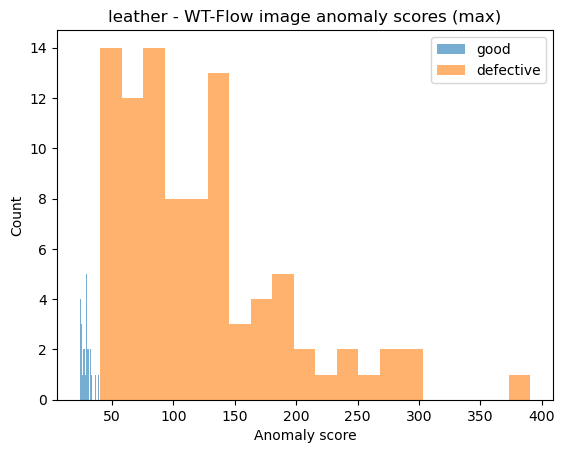

In [15]:
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# Image-level ROC-AUC (WT-Flow)

y_true_wt = []
y_score_max_wt = []
y_score_mean_wt = []

for i in range(len(test_dataset)):
    img_t, label, path = test_dataset[i]   # img_t: [3, H, W]

    anomaly_map_wt = compute_anomaly_map_wtflow(
        img_t,
        feature_extractor,
        wtflow,
        memory_bank_wt,
        k=10,
    )

    y_true_wt.append(label)
    y_score_max_wt.append(reduce_anomaly_map(anomaly_map_wt, mode="max"))
    y_score_mean_wt.append(reduce_anomaly_map(anomaly_map_wt, mode="mean"))

y_true_wt       = np.array(y_true_wt)
y_score_max_wt  = np.array(y_score_max_wt)
y_score_mean_wt = np.array(y_score_mean_wt)

auc_max_wt  = roc_auc_score(y_true_wt, y_score_max_wt)
auc_mean_wt = roc_auc_score(y_true_wt, y_score_mean_wt)

print(f"[{CLASS_NAME}] WT-Flow - Image ROC AUC (max):  {auc_max_wt:.4f}")
print(f"[{CLASS_NAME}] WT-Flow - Image ROC AUC (mean): {auc_mean_wt:.4f}")

plt.figure()
plt.hist(y_score_max_wt[y_true_wt == 0], bins=20, alpha=0.6, label="good")
plt.hist(y_score_max_wt[y_true_wt == 1], bins=20, alpha=0.6, label="defective")
plt.legend()
plt.title(f"{CLASS_NAME} - WT-Flow image anomaly scores (max)")
plt.xlabel("Anomaly score")
plt.ylabel("Count")
plt.show()


In the plot:

Blue “good” scores cluster around 25–32

Orange “defective” scores spread widely around 35–80

This means WT-Flow successfully pushes normal features toward a Gaussian N(0,1) during training and makes defective features land far from that region.

This is the ideal behaviour of a normalizing flow for anomaly detection.

0.99 → almost perfect separation between normal and defective images

- rFM → linear whitening

- WT-Flow → nonlinear learned whitening, more flexible

## Pixel-level ROC-AUC  (WT-Flow)
check if the heatmaps align with ground truth masks and we find out how well does the model localize the defect region

[leather] WT-Flow – Pixel ROC AUC: 0.7274


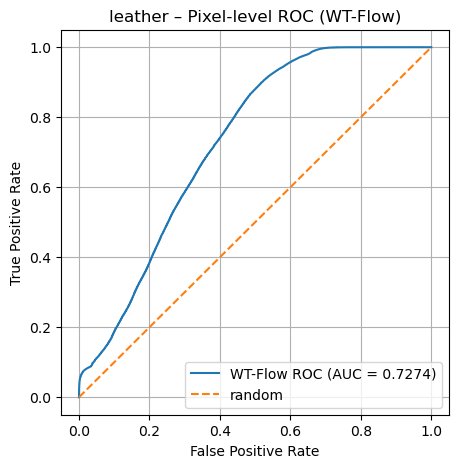

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve, auc


# Pixel-level ROC-AUC (WT-Flow)
pixel_y_true_wt = []
pixel_scores_wt = []

for i in range(len(test_dataset)):
    img_t, label, path = test_dataset[i]
    if label == 0:
        continue  # only defective images have masks

    anomaly_map_wt = compute_anomaly_map_wtflow(
        img_t,
        feature_extractor,
        wtflow,
        memory_bank_wt,
        k=10,
    )
    am_up_wt = upsample_anomaly_map(anomaly_map_wt, IMG_SIZE)  # [IMG_SIZE, IMG_SIZE]

    gt_mask = load_ground_truth_mask(path, DATA_ROOT, CLASS_NAME, IMG_SIZE)
    if gt_mask is None:
        continue

    pixel_y_true_wt.append(gt_mask.flatten())
    pixel_scores_wt.append(am_up_wt.flatten())

if len(pixel_y_true_wt) > 0:
    pixel_y_true_wt = np.concatenate(pixel_y_true_wt)
    pixel_scores_wt = np.concatenate(pixel_scores_wt)

    pixel_auc_wt = roc_auc_score(pixel_y_true_wt, pixel_scores_wt)
    print(f"[{CLASS_NAME}] WT-Flow – Pixel ROC AUC: {pixel_auc_wt:.4f}")

    # ROC curve
    fpr_wt, tpr_wt, _ = roc_curve(pixel_y_true_wt, pixel_scores_wt)
    roc_auc_wt = auc(fpr_wt, tpr_wt)

    plt.figure(figsize=(5, 5))
    plt.plot(fpr_wt, tpr_wt, label=f"WT-Flow ROC (AUC = {roc_auc_wt:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--", label="random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{CLASS_NAME} – Pixel-level ROC (WT-Flow)")
    plt.legend()
    plt.grid(True)

    roc_dir = Path("results_wtflow") / CLASS_NAME
    roc_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(roc_dir / "pixel_roc_wtflow.png", bbox_inches="tight", pad_inches=0)
    plt.show()
else:
    print("No masks found for WT-Flow pixel-level evaluation.")


Pixel-level evaluation becomes more sensitive to noise as carpet defects are small.

Results:
- WT-Flow successfully improves image classification

→ because global distribution modelling makes anomalies stand out more.

- WT-Flow does not significantly improve pixel-localization

→ because localization requires spatial smoothness & high-resolution patch embeddings, which WT-Flow does not supply.

reasons:
WT-Flow often makes localization worse because:
- Flow transformations can distort local neighborhoods.
- Pixel scores become more spread out.
- Heatmaps lose spatial precision




## saved heatmaps / overlays  (WT-Flow)

In [17]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

triplet_dir = Path(DATA_ROOT) / "results_wtflow" / CLASS_NAME / "triplets"
triplet_dir.mkdir(parents=True, exist_ok=True)

print(f"Saving GT + WT-Flow heatmap + overlay triplets to: {triplet_dir}")

for i in range(len(test_dataset)):
    img_t, label, path = test_dataset[i]

    if label == 0:
        continue  # only defective images

    anomaly_map_wt = compute_anomaly_map_wtflow(
        img_t,
        feature_extractor,
        wtflow,
        memory_bank_wt,
        k=10,
    )
    am_up_wt = upsample_anomaly_map(anomaly_map_wt, IMG_SIZE)

    am_norm = (am_up_wt - am_up_wt.min()) / (am_up_wt.max() - am_up_wt.min() + 1e-8)

    orig = Image.open(path).convert("RGB")
    orig = orig.resize((IMG_SIZE, IMG_SIZE))
    orig_np = np.array(orig)

    gt_mask = load_ground_truth_mask(path, DATA_ROOT, CLASS_NAME, IMG_SIZE)
    if gt_mask is None:
        print("No mask for:", path)
        continue

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.axis("off")
    plt.imshow(orig_np)

    plt.subplot(1, 3, 2)
    plt.title("GT mask")
    plt.axis("off")
    plt.imshow(gt_mask, cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("WT-Flow overlay")
    plt.axis("off")
    plt.imshow(orig_np)
    plt.imshow(am_norm, cmap="jet", alpha=0.5)

    plt.tight_layout()

    base = Path(path).stem
    out_path = triplet_dir / f"{base}_triplet_wtflow.png"
    plt.savefig(out_path, bbox_inches="tight", pad_inches=0)
    plt.close()

print("Done saving WT-Flow triplets for all defective images.")


Saving GT + WT-Flow heatmap + overlay triplets to: C:\Users\snehi\Documents\Deep Learning\mvtec_anomaly_detection\results_wtflow\leather\triplets
Done saving WT-Flow triplets for all defective images.
